In [15]:
%matplotlib inline

In [16]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tensorboardX import SummaryWriter
from tqdm import tqdm
import shutil

# from senet.se_resnet import *
from models import *
writer = SummaryWriter('./logs')
plt.ion()   # interactive mode
torch.backends.cudnn.benchmark = True

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Scale(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes


img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

batch_size = 256

transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(img_mean, img_std),
                                    ])
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data/cifar100', train=True, download=True,
                             transform=transform),
            batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data/cifar100', train=False, transform=transform),
            batch_size=batch_size, shuffle=True)
dataloaders = {
    'train': train_loader,
    'val': test_loader
}
# class_names = classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('batch_size: {}'.format(batch_size))
print('train size: {}'.format(len(train_loader)))
print('test size: {}'.format(len(test_loader)))

use_gpu = torch.cuda.is_available()

Files already downloaded and verified
batch_size: 256
train size: 196
test size: 40


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



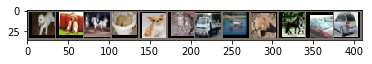

In [18]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
#             ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy()
    if len(inp.shape) > 1:
        inp = inp.transpose((1, 2, 0))
    inp = img_std * inp + img_mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:12]
classes = classes[:12]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=len(classes))

# imshow(out, title=[class_names[x] for x in classes])
imshow(out)

In [19]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = './checkpoints/' + filename
    model_best = './checkpoints/' + 'model_best.pth.tar'
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, model_best)
        
def load_checkpoint(filename = './checkpoints/model_best.pth.tar'):
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('done')
    
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                torch.nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant(m.weight, 1)
            torch.nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            torch.nn.init.normal(m.weight, std=1e-3)
            torch.nn.init.constant(m.bias, 0)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    init_params(model)
    best_model_wts = model.state_dict()
    best_acc = 0.0
    print_every = 20
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            epoch_base_iter = epoch*len(dataloaders[phase])
            if phase == 'train':
                scheduler.step()
                print('current lr: {}'.format(scheduler.get_lr()))
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            epoch_acc = 0.0
            epoch_loss = 0.0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(), requires_grad=False)
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)/preds.size()[0]
  
                if (epoch_base_iter+i)%print_every == print_every-1:
                    # check acc loss of a minibatch per print_every
                    epoch_acc = torch.sum(preds == labels.data)/preds.size()[0]
                    epoch_loss = loss.data[0]
                  
                    print('{} Loss: {:.4f} Acc: {:.4f} iter: {}'.format(
                        phase, epoch_loss, epoch_acc,epoch_base_iter + i+1))
                    
                    if phase == 'train':
                        writer.add_scalar('train_loss', epoch_loss,epoch_base_iter + i+1)
                        writer.add_scalar('train_accuracy', epoch_acc, epoch_base_iter + i+1)
                    elif phase == 'val':
                        writer.add_scalar('val_loss', epoch_loss,epoch_base_iter + i+1)
                        writer.add_scalar('val_accuracy', epoch_acc, epoch_base_iter + i+1)
                        
#                     for tag, value in model.named_parameters():
# #                         tag = tag.replace('.', '/')
#                         writer.add_histogram(tag, value.data.cpu().numpy(), epoch_base_iter + i+1)
#                         writer.add_histogram(tag+'/grad', value.grad.data.cpu().numpy(), epoch_base_iter + i+1)
        
                del loss, outputs, preds, inputs, labels, data
                # it's necessary here, otherwise peak gpu usage will go high when switch to val
    
            # acc loss of one epoch
            epoch_acc = running_corrects/len(dataloaders[phase])
            epoch_loss = running_loss/len(dataloaders[phase])
            if phase == 'train':
                writer.add_scalar('epoch_train_loss', epoch_loss,epoch+1)
                writer.add_scalar('epoch_train_accuracy', epoch_acc,epoch+1)
            elif phase == 'val':
                writer.add_scalar('epoch_val_loss', epoch_loss,epoch+1)
                writer.add_scalar('epoch_val_accuracy', epoch_acc,epoch+1)
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
#     model.load_state_dict(best_model_wts)
    save_checkpoint({
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
        }, True, 'cp.pth.tar')
    return model

In [20]:
model_conv = ResNet18() # default num_classes=10
# for param in model_conv.parameters():
#     param.requires_grad = False
if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=30, gamma=0.2)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
current lr: [0.05]
train Loss: nan Acc: 0.1367 iter: 20
train Loss: nan Acc: 0.1367 iter: 40


KeyboardInterrupt: 

In [ ]:
visualize_model(model_conv)
writer.close()
plt.ioff()
plt.show()